<big><h1>Named Entity Recognition on EMBO SourceData-NLP</h1>

<big><i>By Kirill Tsukanov, ktsukanov@ebi.ac.uk</i>

# 1. Scope of this notebook
<big>Training and evaluating ML models can be quite resource intensive. This being a technical exercise, I wanted to keep this notebook consise, so that I can showcase the principles while avoiding getting bogged down in technical details.

<big>I also wanted this notebook to be able to run in reasonable time on a modern machine, so I had to simplify some things. To highlight these, and to explain how I would have done things differently for a serious production implementation, I added notes throughout this notebook.

<div class="alert alert-warning">
<big>🖛 These notes will look like this.
</div>

# 2. Dataset selection
<big>I used two resources to search for datasets: [Hugging Face](https://huggingface.co/datasets) and [Papers With Code](https://paperswithcode.com/datasets). While scouting the latter for the most recent datasets tagged as “NER” and “Biomedical”, I found this really interesting one: [**EMBO SourceData-NLP**](https://paperswithcode.com/paper/the-sourcedata-nlp-dataset-integrating).

## 2.1. Why SourceData-NLP?
<big>There are several things that I liked about it:
* <big>**Recent.** First release in March 2023, latest update in September 2023.
* <big>**Open.** The dataset is published under the permissive [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/deed.en) license.
* <big>**Manually curated.** All entries in the dataset are added by human curators, with spot checks from a second curator.
* <big>**Reputable source.** The dataset is published by [EMBO](https://www.embo.org/) (European Molecular Biology Organization), closely affiliated with EMBL.

<big>And most importantly...

## 2.2. Novel approach
<big>While other datasets focus on abstracts (easy to curate = higher numbers, but limited information) or full texts (lots of information, but hard to curate = lower numbers), this one focuses on figure captions. The authors give the following rationale in the paper:
* <big>The _primary_ source of most novel biomedical findings in the papers are **figures,** like cell microphotographs or assay results.
* <big>The _next closest_ source which we can process with NLP are **figure captions** describing those experimental results.
* <big>Figure captions use standard language and format, are not very long, and have high information density.

## 2.3. Organisational considerations
<big>Finally, I liked the organisational approach the authors took to curating the dataset: the curation was done at the same time as accepting the papers for publication. This guarantees very up-to-date information in the dataset, and also curators can (and do) contact authors of the paper if they are unsure how to interpret anything in the figure caption.

## 2.4. Dataset overview
<big>Statistics:
- <big>25 scientific journals
- <big>3 223 papers
- <big>18 689 figures
- <big>62 543 panels (semantically distinct parts of figures)
- <big>661 862 curated entities
  + Out of them, 623 162 linked to ontologies

<big>Types of curated entities:
* <big>Gene products
* <big>Chemicals or small molecules
* <big>Cells
* <big>Tissues
* <big>Subcellular locations
* <big>Organism or species
* <big>Experimental assay
* <big>Disease

<div class="alert alert-warning">
<big>🖛 While the dataset is novel and interesting, the authors themselves note in the paper that it has some limitations. For example, certain classes tend to be underrepresented in figure captions. This is especially true for diseases.
</div>

# 3. Technical setup
<big>This section sets up the necessary software, environment, and modules to run the notebook. This notebook was tested on Ubuntu 22.04 LTS. However, with minor modifications (see comments in the next two blocks) it should be possible to run it on any platform where Python is supported.

<big>The machine which ran the code had a 12 core CPU, 64 GB of RAM, and a NVIDIA GeForce 3080 12GB GPU.

<div class="alert alert-warning">
<big>🖛 I am aware that the use of GPUs in academia is associated with certain controversies and sustainability concerns. Since I did have a GPU at hand, I decided to use for this exercise to speed up the computations. However, in principle all commands could be run on a CPU as well, as PyTorch provides a seamless interface to switch between them.
</div>

In [1]:
# # Install Python and core modules.
# # NOTE: syntax is specific to Ubuntu/Debian and will differ for other platforms.
# ! sudo apt -qqq update
# ! sudo apt -qqq install -y \
#     python3 \
#     python3-pip \
#     python3-venv

In [2]:
# Set up the virtual environment.
# NOTE: syntax is specific to Linux/Mac and will differ for other platforms.
! python3 -m venv env
! source env/bin/activate

In [ ]:
# Install Python libraries.
! pip -q install --no-warn-script-location \
    accelerate==0.26.1 \
    datasets==2.16.1 \
    ipywidgets==8.1.1 \
    matplotlib==3.8.2 \
    pandarallel==1.6.5 \
    pandas==2.2.0 \
    scikit-learn==1.4.0 \
    scipy==1.12.0 \
    seaborn==0.13.2 \
    torch==2.2.0 \
    transformers==4.37.2

In [ ]:
# Import built-in modules.
import collections
import os
import json
import warnings

# Import third-party modules.
import datasets
with warnings.catch_warnings():
    # Suppress matplotlib Axes3D warning.
    warnings.simplefilter("ignore", category=UserWarning)
    import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
import sklearn.metrics
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import BertTokenizerFast, BertForTokenClassification, DistilBertForTokenClassification

In [ ]:
# Enable parallel Pandas computation.
pandarallel.initialize(nb_workers=os.cpu_count())

# Suppress transformer warnings (for example, that a newly instantiated model has not been trained).
from transformers import logging
logging.set_verbosity_error()

# 4. Fetch and investigate the dataset

In [ ]:
ds = datasets.load_dataset(
    "EMBO/SourceData",
    "NER",
    version="2.0.3",
    trust_remote_code=True
)

## 4.1. Basic information

In [ ]:
ds

<big>We can see that the dataset is already split into train/test/validation subsets. I will use them throughout this notebook. In order to avoid any subconscious bias, and in line with best practices for developing ML pipelines, I will never look directly inside the test and validation sets.

## 4.2. Features

In [ ]:
ds["train"].features

## 4.3. Labels

In [ ]:
ds["train"].features["labels"].feature.names

<big>We can see that the labels are annotated in the standard IOB (inside-outside-beginning) notation.

# 5. Preprocess data
<big>The data is currently broken down into words. In order to be able to run ML models, we need to tokenise them. Because the number of sub-word tokens isn't going to match the number of original words (and by consequence, labels), we need to make sure the labels are updated following the transformation.

## 5.1. Convert into Pandas

In [ ]:
# Convert the dataset to a Pandas DataFrame.
df = pd.DataFrame(ds['train'])

# Define all data subsets to make operating on them easier.
ALL_SUBSETS = ("train", "validation", "test")
df = dict()

# Select the columns we are going to need.
for subset in ALL_SUBSETS:
    df[subset] = pd.DataFrame(ds[subset])[["words", "labels"]]

df["train"]

## 5.2. Recover word IOB labels
<big>Since the tokens represent sub-words, their number is going to be greater than the original number of words (and correspondingly, labels). Because of that, we need to accurately transform the word labels into token labels. But in order to do that, we need to first recover the original IOB word labels.

In [ ]:
LABELS = ds["train"].features["labels"].feature.names

def recover_labels(labels):
    return [LABELS[x] for x in labels]

for subset in ALL_SUBSETS:
    df[subset]["labels_str"] = df[subset]["labels"].parallel_apply(recover_labels)

df["train"]

## 5.3. Tokenise and compute token IOB labels
<big>At this point, we can apply the tokeniser. It's essential to adjust the labels, as the number of tokens is going to be greater than the number of words.

In [ ]:
# Load the pre-trained tokeniser.
MODEL_NAME = "bert-base-uncased"
tokeniser = BertTokenizerFast.from_pretrained(MODEL_NAME)

In [ ]:
df

In [13]:
def repeat_word_label(label, repetitions):
    """Convert word IOB labels into token IOB labels for a given word."""

    if label == "O" or label.startswith("I-"):
        # Inside and outside labels are just repeated with no modifications.
        return [label] * repetitions

    if label.startswith("B-"):
        # For a "before" label, we need to convert into `1` of "before" and `repetitions-1` of "inside".
        inside_label = "I-" + label[2:]
        return [label] + ([inside_label] * (repetitions - 1))

<div class="alert alert-warning">
<p><big>🖛 The maximum number of tokens in one sentence that <small><code>bert-base-uncased</code></small> supports is 512. After tokenising, some sentences are going to have more than 512 tokens. I have verified (not shown here) that it only affects a slight minority of them, as almost all figure captions will fit under this threshold.
<p>For simplicity, here I just pad+truncate all sentences to 512 sub-word tokens. However, there are of course more clever ways to do this: we could choose a larger model which supports longer context, or we could have broken down long sentences into several smaller ones (with overlap) and then stiched it back together.
</div>

In [14]:
def tokenise_and_convert_labels(row):
    """Tokenise words and convert all word IOB labels into token IOB labels."""
    
    # Make sure that rows and labels match.
    assert len(row.words) == len(row.labels), "The lengths of words and labels vectors do not match"
    
    # Tokenise.
    tokens = tokeniser(
        row.words,
        max_length=512,
        padding="max_length",
        truncation=True,
        is_split_into_words=True
    )
    
    # Calculate how many tokens does each word have.
    word_token_count = collections.Counter(tokens.word_ids())

    # Compute token IOB labels.
    token_iob_labels = []
    for i, label in enumerate(row.labels_str):
        token_iob_labels.extend(
            repeat_word_label(label, word_token_count[i])
        )
 
    # Pad labels to match special tokens: [CLS], [SEP], and [PAD] (multiple).
    token_iob_labels = [None] + token_iob_labels + [None]
    token_iob_labels += [None] * (512 - len(token_iob_labels))
    token_iob_labels = token_iob_labels[:512]
    
    return tokens.input_ids, token_iob_labels, tokens.attention_mask

In [15]:
for subset in ALL_SUBSETS:
    df[subset][["tokens", "token_labels", "attention_mask"]] = df[subset].parallel_apply(
        tokenise_and_convert_labels, axis=1, result_type="expand"
    )

In [16]:
df["train"]

,words,labels,labels_str,tokens,token_labels,attention_mask
0,"[B, -, D, Left, ventricular, LXRα, expression,...","[0, 0, 0, 9, 10, 3, 0, 0, 0, 0, 3, 0, 0, 11, 0...","[O, O, O, B-TISSUE, I-TISSUE, B-GENEPROD, O, O...","[101, 1038, 1011, 1040, 2187, 18834, 7277, 793...","[None, O, O, O, B-TISSUE, I-TISSUE, I-TISSUE, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[B, -, D, Left, ventricular, LXRα, expression,...","[0, 0, 0, 9, 10, 3, 0, 0, 0, 0, 3, 0, 0, 11, 0...","[O, O, O, B-TISSUE, I-TISSUE, B-GENEPROD, O, O...","[101, 1038, 1011, 1040, 2187, 18834, 7277, 793...","[None, O, O, O, B-TISSUE, I-TISSUE, I-TISSUE, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[E, LV, weight, to, tibia, length, ratios, (, ...","[0, 9, 13, 0, 9, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0,...","[O, B-TISSUE, B-EXP_ASSAY, O, B-TISSUE, O, O, ...","[101, 1041, 1048, 2615, 3635, 2000, 14841, 116...","[None, O, B-TISSUE, I-TISSUE, B-EXP_ASSAY, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[F, Assessment, of, mean, arterial, pressure, ...","[0, 0, 0, 0, 13, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[O, O, O, O, B-EXP_ASSAY, I-EXP_ASSAY, O, O, O...","[101, 1042, 7667, 1997, 2812, 25543, 3778, 100...","[None, O, O, O, O, B-EXP_ASSAY, I-EXP_ASSAY, O...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[G, Representative, Masson, ', s, trichrome, a...","[0, 0, 13, 14, 14, 14, 0, 3, 4, 4, 0, 13, 0, 0...","[O, O, B-EXP_ASSAY, I-EXP_ASSAY, I-EXP_ASSAY, ...","[101, 1043, 4387, 3742, 2239, 1005, 1055, 1301...","[None, O, O, B-EXP_ASSAY, I-EXP_ASSAY, I-EXP_A...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
60261,"[(, D, ), E14, ., 5, cortices, stained, with, ...","[0, 0, 0, 0, 0, 0, 9, 13, 0, 0, 0, 3, 0, 0, 0,...","[O, O, O, O, O, O, B-TISSUE, B-EXP_ASSAY, O, O...","[101, 1006, 1040, 1007, 1041, 16932, 1012, 101...","[None, O, O, O, O, O, O, O, B-TISSUE, I-TISSUE...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
60262,"[(, E, ), Ratio, of, mitotic, (, PH3, +, ), to...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-GENE...","[101, 1006, 1041, 1007, 6463, 1997, 10210, 202...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
60263,"[(, F, Quantification, of, the, number, of, (,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 14, 0, 0, 0...","[O, O, O, O, O, O, O, O, O, O, B-EXP_ASSAY, I-...","[101, 1006, 1042, 24110, 3775, 10803, 1997, 19...","[None, O, O, O, O, O, O, O, O, O, O, O, O, B-E...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
60264,"[G, ), Quantification, of, the, number, of, (,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-GENEPRO...","[101, 1043, 1007, 24110, 3775, 10803, 1997, 19...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## 5.4. Encode the token IOB labels
<big>Because the token labels are now still strings (IOB), we need to encode them as integers for the model.

In [17]:
token_label_encoding = {label: i for i, label in enumerate(LABELS, 1)}
token_label_encoding[None] = 0  # For special tokens like [CLS], [SEP], [PAD].
token_label_encoding

{'O': 1,
 'B-SMALL_MOLECULE': 2,
 'I-SMALL_MOLECULE': 3,
 'B-GENEPROD': 4,
 'I-GENEPROD': 5,
 'B-SUBCELLULAR': 6,
 'I-SUBCELLULAR': 7,
 'B-CELL_TYPE': 8,
 'I-CELL_TYPE': 9,
 'B-TISSUE': 10,
 'I-TISSUE': 11,
 'B-ORGANISM': 12,
 'I-ORGANISM': 13,
 'B-EXP_ASSAY': 14,
 'I-EXP_ASSAY': 15,
 'B-DISEASE': 16,
 'I-DISEASE': 17,
 'B-CELL_LINE': 18,
 'I-CELL_LINE': 19,
 None: 0}

In [18]:
# We will need this later when we want to go back from indexes to the source labels.
token_label_decoding = {v: k for k, v in token_label_encoding.items()}

In [19]:
def encode_token_labels(token_labels):
    return [token_label_encoding[x] for x in token_labels]

In [20]:
for subset in ALL_SUBSETS:
    df[subset]["encoded_token_labels"] = df[subset]["token_labels"].parallel_apply(encode_token_labels)

In [21]:
df["train"]

,words,labels,labels_str,tokens,token_labels,attention_mask,encoded_token_labels
0,"[B, -, D, Left, ventricular, LXRα, expression,...","[0, 0, 0, 9, 10, 3, 0, 0, 0, 0, 3, 0, 0, 11, 0...","[O, O, O, B-TISSUE, I-TISSUE, B-GENEPROD, O, O...","[101, 1038, 1011, 1040, 2187, 18834, 7277, 793...","[None, O, O, O, B-TISSUE, I-TISSUE, I-TISSUE, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 10, 11, 11, 11, 4, 5, 5, 5, 1, 1,..."
1,"[B, -, D, Left, ventricular, LXRα, expression,...","[0, 0, 0, 9, 10, 3, 0, 0, 0, 0, 3, 0, 0, 11, 0...","[O, O, O, B-TISSUE, I-TISSUE, B-GENEPROD, O, O...","[101, 1038, 1011, 1040, 2187, 18834, 7277, 793...","[None, O, O, O, B-TISSUE, I-TISSUE, I-TISSUE, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 10, 11, 11, 11, 4, 5, 5, 5, 1, 1,..."
2,"[E, LV, weight, to, tibia, length, ratios, (, ...","[0, 9, 13, 0, 9, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0,...","[O, B-TISSUE, B-EXP_ASSAY, O, B-TISSUE, O, O, ...","[101, 1041, 1048, 2615, 3635, 2000, 14841, 116...","[None, O, B-TISSUE, I-TISSUE, B-EXP_ASSAY, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 10, 11, 14, 1, 10, 11, 1, 1, 1, 10, 11,..."
3,"[F, Assessment, of, mean, arterial, pressure, ...","[0, 0, 0, 0, 13, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[O, O, O, O, B-EXP_ASSAY, I-EXP_ASSAY, O, O, O...","[101, 1042, 7667, 1997, 2812, 25543, 3778, 100...","[None, O, O, O, O, B-EXP_ASSAY, I-EXP_ASSAY, O...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 14, 15, 1, 1, 1, 1, 1, 1, 1, 1..."
4,"[G, Representative, Masson, ', s, trichrome, a...","[0, 0, 13, 14, 14, 14, 0, 3, 4, 4, 0, 13, 0, 0...","[O, O, B-EXP_ASSAY, I-EXP_ASSAY, I-EXP_ASSAY, ...","[101, 1043, 4387, 3742, 2239, 1005, 1055, 1301...","[None, O, O, B-EXP_ASSAY, I-EXP_ASSAY, I-EXP_A...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 14, 15, 15, 15, 15, 15, 1, 4, 5, 5, ..."
...,...,...,...,...,...,...,...
60261,"[(, D, ), E14, ., 5, cortices, stained, with, ...","[0, 0, 0, 0, 0, 0, 9, 13, 0, 0, 0, 3, 0, 0, 0,...","[O, O, O, O, O, O, B-TISSUE, B-EXP_ASSAY, O, O...","[101, 1006, 1040, 1007, 1041, 16932, 1012, 101...","[None, O, O, O, O, O, O, O, B-TISSUE, I-TISSUE...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 10, 11, 11, 14, 1, 1,..."
60262,"[(, E, ), Ratio, of, mitotic, (, PH3, +, ), to...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-GENE...","[101, 1006, 1041, 1007, 6463, 1997, 10210, 202...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
60263,"[(, F, Quantification, of, the, number, of, (,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 14, 0, 0, 0...","[O, O, O, O, O, O, O, O, O, O, B-EXP_ASSAY, I-...","[101, 1006, 1042, 24110, 3775, 10803, 1997, 19...","[None, O, O, O, O, O, O, O, O, O, O, O, O, B-E...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14, 15..."
60264,"[G, ), Quantification, of, the, number, of, (,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-GENEPRO...","[101, 1043, 1007, 24110, 3775, 10803, 1997, 19...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


# 6. Set up framework for hyperparameter tuning and training
<big>We are going to be repeatedly training the model while varying hyperparameters and benchmarking it on the validation set to find the best combination. As such, it makes sense to set up a framework so that we can easily run training/validation and get the results.

<big>As a criteria for model "quality", I will be using an average macro F1 score. This should overall assess model quality well, taking into account imbalances between classes.

<big>One we have the best final model, we will look into a detailed classification report.

In [22]:
class SourceData:
    
    def __init__(self, df, num_labels, f1_aggregation, save_prefix, model=None,
                 truncate_subsets=None, is_distil_bert=False):
        """Initialise the class."""
        self.df = df
        self.num_labels = num_labels
        self.f1_aggregation = f1_aggregation
        self.save_prefix = save_prefix
        
        # If a model is provided, then loaded; otherwise initialise a base model.
        if model:
            if is_distil_bert:
                self.model = DistilBertForTokenClassification.from_pretrained(model)
            else:
                self.model = BertForTokenClassification.from_pretrained(model)
        else:
            self.base_model()
        
        # To speed up calculations, we might want to truncate some of the subsets.
        if truncate_subsets:
            for subset, num_of_records in truncate_subsets.items():
                self.df[subset] = self.df[subset].head(num_of_records)        
    
    def base_model(self):
        self.model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=self.num_labels)
    
    def get_tensors(self, subset):
        """Prepare tensors for the specified subset: tokens, attention mask, labels."""
        return [
            torch.tensor(
                self.df[subset][column].tolist()
            )
            for column in (
                "tokens", "attention_mask", "encoded_token_labels"
            )
        ]

    def collapse_labels(self, label_indices):
        """Convert label indices to the source labels and collapse I-SOMECLASS/B-SOMECLASS into SOMECLASS."""
        labels = [token_label_decoding[i] for i in label_indices]
        collapsed_labels = [
            (
                str(label[2:])
                if str(label).startswith("I-") or str(label).startswith("B-")
                else str(label)
            )
            for label in labels
        ]
        return collapsed_labels

    def evaluate(self, device, subset, collapse_labels=False):
        """Check model's aggregated F1 performance."""
        
        # Set up hardware.
        device = torch.device(device)
        self.model.to(device)
        
        # Put model into evaluation mode.
        self.model.eval()
                
        # Prepare data.
        val_dataset = TensorDataset(*(self.get_tensors(subset)))
        val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Lists to store predictions and true labels.
        all_predictions = []
        all_true_labels = []

        # Iterate over the validation set.
        with torch.no_grad():
            for batch in tqdm(val_dataloader, f"[evaluate] [{subset}]"):
                batch = tuple(t.to(device) for t in batch)
                inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

                # Forward pass.
                outputs = self.model(**inputs)
                logits = outputs.logits

                # Get predictions, attention mask, true labels.
                predictions = torch.argmax(logits, dim=2).cpu().numpy().flatten()
                attention_mask = batch[1].cpu().numpy().flatten()
                true_labels = batch[2].cpu().numpy().flatten()

                # Exclude padding tokens from calculations.
                all_predictions.extend(predictions[attention_mask == 1])
                all_true_labels.extend(true_labels[attention_mask == 1])

        if collapse_labels:
            all_predictions = self.collapse_labels(all_predictions)
            all_true_labels = self.collapse_labels(all_true_labels)
                
        # Calculate and return the classification report and the F1 score.
        f1 = sklearn.metrics.f1_score(
            all_true_labels,
            all_predictions,
            average=self.f1_aggregation,
        )
        with warnings.catch_warnings():
            # Suppress warnings when some labels did not occur in the predicted values.
            warnings.simplefilter("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
            classification_report = sklearn.metrics.classification_report(
                all_true_labels,
                all_predictions,
            )
        return f1, classification_report

    def train_validate_save(self, device, num_epochs, learning_rate, batch_size):
        """Runs several epochs of training the model with given learning rate and batch size.
        After each training cycle, also computes F1 score.
        Returns a list of F1 scores for each training epoch."""
        
        # Prepare data.
        train_dataset = TensorDataset(*(self.get_tensors("train")))
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Initialise the optimiser.
        optimiser = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        
        # Set up hardware.
        device = torch.device(device)
        self.model.to(device)
        
        # Train/validate/save cycle.
        f1_values = []
        for epoch in range(1, num_epochs+1):
            
            # Train.
            self.model.train()
            tqdm_desc = (
                f"[train] "
                f"lr {learning_rate}, "
                f"bs {batch_size}, "
                f"epoch {epoch}/{num_epochs}"
            )
            for batch in tqdm(train_dataloader, desc=tqdm_desc):
                optimiser.zero_grad()
                batch = tuple(t.to(device) for t in batch)
                outputs = self.model(input_ids=batch[0], attention_mask=batch[1], labels=batch[2])
                loss = outputs[0]
                loss.backward()
                optimiser.step()
                
            # Validate.
            f1, _ = self.evaluate(device=device, subset="validation", collapse_labels=True)
            f1_values.append(f1)
            
            # Save.
            self.model.save_pretrained(f"{self.save_prefix}_{learning_rate}_{batch_size}_{epoch}")
        
        # Clean up memory and return.
        del self.model
        self.empty_model()
        return f1_values

# 7. Train model and tune hyperparameters

<big>First, we set some common parameters to be used throughout the process.

<div class="alert alert-warning">
<p><big> 🖛 Although we have a substantial training set size of more than 60,000 records, it's not feasible (for a technical exercise) to train on the entire set, especially considering that we want to tune hyperparameters. This is because, even on a GPU, it takes about 1.5 hours for one training epoch on the full 60,000 records.
<p>Because of that, I truncate the subsets as described below. This will, of course, degrate model performance, but will not prevent us from demonstrating all of the basic principles. If we wanted to run the same code on a bigger dataset, it's just the matter of adjusting or removing constraints below, and then waiting for longer.
</div>

<div class="alert alert-warning">
<p><big>🖛 While I use simple truncation for simplicity, we could also have used more sophisticated ways to cut down a training set. For example, we could try to use stratified sampling to make sure the classes are more evenly present in the skimmed down training set, but again I feel this is outside of the scope of this technical exercise.
</div>

In [23]:
# Truncating subsets for increased performance.
TRUNCATE_TRAIN = 6144
TRUNCATE_VALIDATION = 1536
# Test set is not truncated.

<div class="alert alert-warning">
<p><big>🖛 For a production task, I would have varied the hyperparameters more (not just a few values) and increased the number of epochs.
</div>
<div class="alert alert-warning">
<p><big>🖛 Rather than varying the parameters manually, it is possible to use frameworks like Optuna, but again I feel this is an overkill for the scope of this exercise.
</div>

In [24]:
# Hyperparameters.
NUM_EPOCHS = 3
LEARNING_RATES = [
    3e-5,
    5e-5,
]
BATCH_SIZES = [
    8,
    16,
]

<div class="alert alert-warning">
<p><big>🖛 The reason I chose to use macro aggregation for the F1 metrics is because it seems to be the least sensitive to the over-abundance of the <small><code>O</code></small> class, and more sensitive to how well the actual entity classes are predicted. Overall it seems to be the most “pessimistic” metric, which I thought would be good to better reflect the training progress.
</div>

In [25]:
# Aggregation for F1.
F1_AGGREGATION = "macro"

In [26]:
# Prefix for saving the models.
SAVE_PREFIX = "model_v4"

In [27]:
SD = SourceData(
    df=df,
    num_labels=len(token_label_encoding),
    f1_aggregation=F1_AGGREGATION,
    save_prefix=SAVE_PREFIX,
    truncate_subsets={"train": TRUNCATE_TRAIN, "validation": TRUNCATE_VALIDATION}
)
f1_data = []

for learning_rate in LEARNING_RATES:
    for batch_size in BATCH_SIZES:
        f1_scores = SD.train_validate_save(
            device="cuda",
            num_epochs=NUM_EPOCHS,
            learning_rate=learning_rate,
            batch_size=batch_size
        )
        for epoch, f1 in enumerate(f1_scores, 1):
            f1_data.append([learning_rate, batch_size, epoch, f1])

[evaluate] [validation]: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it]


<big>We can now visualise the results.

In [28]:
f1_df = pd.DataFrame(f1_data, columns=["learning_rate", "batch_size", "epoch", "agg_f1"])
f1_df

,learning_rate,batch_size,epoch,agg_f1
0,0.00003,8,1,0.744670
1,0.00003,8,2,0.781494
2,0.00003,8,3,0.779147
3,0.00003,16,1,0.693277
4,0.00003,16,2,0.770304
5,0.00003,16,3,0.767005
6,0.00005,8,1,0.753977
7,0.00005,8,2,0.779534
8,0.00005,8,3,0.776964
9,0.00005,16,1,0.718923


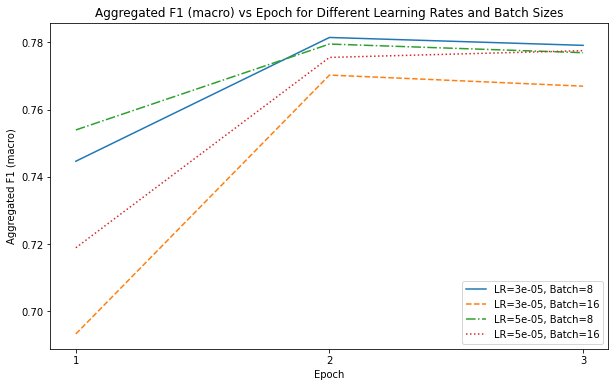

In [29]:
# Grouping by unique combinations of learning_rate and batch_size.
grouped_df = f1_df.groupby(["learning_rate", "batch_size"])

# Define line styles for better visibility.
line_styles = ['-', '--', '-.', ':']

# Plotting for each group with different line styles.
fig, ax = plt.subplots(figsize=(10, 6))

for i, (name, group) in enumerate(grouped_df):
    learning_rate, batch_size = name
    line_style = line_styles[i % len(line_styles)]
    ax.plot(group["epoch"], group["agg_f1"], label=f"LR={learning_rate}, Batch={batch_size}", linestyle=line_style)

# Adding labels and legend.
ax.set_xlabel("Epoch")
ax.set_ylabel(f"Aggregated F1 ({F1_AGGREGATION})")
ax.set_title(f"Aggregated F1 ({F1_AGGREGATION}) vs Epoch for Different Learning Rates and Batch Sizes")
ax.legend()

# Setting the X-axis format as integer.
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

# Setting ticks every 1 (no fractional values).
ax.set_xticks(np.arange(min(f1_df["epoch"]), max(f1_df["epoch"])+1, 1.0))

# Show the plot.
plt.show()

# 8. Evalutate the best model

<big>Based on the results of the above comparison, we can now detect and evaluate the best model, and see how it performs on various classes.

In [30]:
# Detect the best model.
max_index = f1_df['agg_f1'].idxmax()
row = f1_df.loc[max_index]
best_model = f"{SAVE_PREFIX}_{row.learning_rate}_{int(row.batch_size)}_{int(row.epoch)}"
print(f"The best model is {best_model}")

The best model is model_v4_3e-05_8_2


In [31]:
SD_best = SourceData(
    df=df,
    num_labels=len(token_label_encoding),
    f1_aggregation=F1_AGGREGATION,
    save_prefix=SAVE_PREFIX,
    model=f"{os.getcwd()}/{best_model}"
)
f1_score, classification_report = SD_best.evaluate(device="cuda", subset="test", collapse_labels=True)

[evaluate] [test]: 100%|██████████| 210/210 [03:37<00:00,  1.04s/it]


In [32]:
print(classification_report)

                precision    recall  f1-score   support

     CELL_LINE       0.86      0.84      0.85      7640
     CELL_TYPE       0.74      0.72      0.73      7903
       DISEASE       0.56      0.55      0.56      1791
     EXP_ASSAY       0.80      0.76      0.78     34215
      GENEPROD       0.87      0.84      0.85     70668
          None       1.00      1.00      1.00     13386
             O       0.96      0.96      0.96    487235
      ORGANISM       0.87      0.72      0.78      7948
SMALL_MOLECULE       0.62      0.81      0.70     19728
   SUBCELLULAR       0.68      0.73      0.70     10181
        TISSUE       0.77      0.72      0.75      7813

      accuracy                           0.92    668508
     macro avg       0.79      0.79      0.79    668508
  weighted avg       0.92      0.92      0.92    668508



<big>As we can see, performance of the model is quite good! It's even more impressive considering that:
* <big>I used <small>`bert-base-uncased`</small> which isn't nearly state of the art even across open source models, and it only has 110M parameters;
* <big>Training set was significantly constrained to increase performance;
* <big>The number of hyperparameter combinations & epochs was not high.

<big>Similarly to the results reported in the original paper, we can see that classes vary in their F1 scores quite significantly. This is due to the fact of them that some of them are more abundant, and/or more straightforward to grasp, than others. As in the paper, the worst performance that we observe is with the “disease” class.

# 9. Optimising inference time via knowledge distillation

<big>In production, we want the inference on the model to be running quickly, and depending on the task we might be willing to sacrifice some quality.

<big>The idea behind model compression via knowledge distillation is that a smaller “student” model is trained with the larger model serving as a “teacher”. A smaller model will not be as good as the large one, but we can hope to make it faster and achieve a good tradeoff.

In [33]:
# Prepare teacher and student models.
teacher_model = SD_best.model
student_model = DistilBertForTokenClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(token_label_encoding)
)

# Prepare input data.
train_dataset = TensorDataset(*[
    torch.tensor(
        df["train"][:TRUNCATE_TRAIN][column].tolist()
    )
    for column in (
        "tokens", "attention_mask", "encoded_token_labels"
    )
])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Prepare devices.
teacher_model.cuda()
student_model.cuda()

# Set the teacher model in evaluation mode.
teacher_model.eval()

# Define the loss function and optimizer.
loss_function = torch.nn.KLDivLoss(reduction="batchmean")
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5)
distillation_epochs = 5

# Start training loop.
for epoch in range(1, distillation_epochs+1):
    for batch in tqdm(train_dataloader, f"[distillation] epoch {epoch}/{distillation_epochs}"):
        optimizer.zero_grad()

        # Move tensors to GPU.
        input_ids = batch[0].cuda()
        attention_mask = batch[1].cuda()
        labels = batch[2].cuda()

        # Forward pass through the student model.
        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)[0]

        # Forward pass through the teacher model.
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)[0]

        # Calculate the loss.
        loss = loss_function(torch.log_softmax(student_outputs, dim=-1), torch.softmax(teacher_outputs, dim=-1))

        # Backward pass.
        loss.backward()
        optimizer.step()

[distillation] 5/5: 100%|██████████| 1536/1536 [08:38<00:00,  2.96it/s]


In [34]:
# Save the student model.
student_model.eval()
student_model.save_pretrained(f"{os.getcwd()}/{SAVE_PREFIX}_student")

In [35]:
# Evaluate the student model on the test set.
SD_student = SourceData(
    df=df,
    num_labels=len(token_label_encoding),
    f1_aggregation=F1_AGGREGATION,
    save_prefix=SAVE_PREFIX,
    model=f"{os.getcwd()}/{SAVE_PREFIX}_student",
    is_distil_bert=True,
)
f1_score, classification_report = SD_student.evaluate(device="cuda", subset="test", collapse_labels=True)

[evaluate] [test]: 100%|██████████| 210/210 [01:49<00:00,  1.92it/s]


In [36]:
f1_score

0.7772801545971528

In [37]:
print(classification_report)

                precision    recall  f1-score   support

     CELL_LINE       0.92      0.74      0.82      7640
     CELL_TYPE       0.74      0.65      0.69      7903
       DISEASE       0.62      0.50      0.55      1791
     EXP_ASSAY       0.80      0.76      0.78     34215
      GENEPROD       0.85      0.85      0.85     70668
          None       1.00      1.00      1.00     13386
             O       0.96      0.96      0.96    487235
      ORGANISM       0.87      0.71      0.78      7948
SMALL_MOLECULE       0.63      0.74      0.68     19728
   SUBCELLULAR       0.69      0.71      0.70     10181
        TISSUE       0.75      0.72      0.73      7813

      accuracy                           0.92    668508
     macro avg       0.80      0.76      0.78    668508
  weighted avg       0.92      0.92      0.92    668508



<big>Results of knowledge distillation:
| <big>Model | <big>Type | <big>Number of parameters | <big>Inference time | <big>Macro F1 | <big>Weighted F1 |
|:---|:---|:---|:---|:---|:---|
| <big>original | <big>BERT | <big>110M | <big>3m 37s | <big>0.79 | <big>0.92 |
| <big>distilled | <big>DistilBERT | <big>66M | <big>1m 50s | <big> 0.78 | <big> 0.92 |
| <big>(change) |  |  | <big>50% faster | <big>&lt;1% decrease | <big>no change |

<big>The results are amazing: virtually no change in both macro and weighted average F1 scores (although there are some single percentage point degradations in individual classes), while inference is twice as fast!

# 10. Conclusion

<big>I enjoyed doing this exercise with transformers. It was relatively easy to obtain good enough results even when aiming for quick execution time. The following improvements could be made if this were to be continued as a production grade task:

<div class="alert alert-warning">
<big>🖛 <b>Main training stage</b>

- Larger models as a base for main training stage
- Models pretrained on biomedical knowledge such as PubMedBERT or BioLinkBERT
- More epochs
- Vary hyperparameters more
- Use the full available training set
</div>

<div class="alert alert-warning">
<big>🖛 <b>Optimising for production</b>

- Try an even smaller model than DistilBERT to see if we can make it work
- Add some hyperparameter varying for this stage, too
- More epochs for the distillation stage
- Try to use quantisation to see if we can optimise further
    </div>

<big>I'm sure there are more things, but these are the ones I could think of.

<big>That's all for now, and thank you for reading!<br>*— Kirill*